# MASTML

In [23]:
import pickle
import numpy as np
import pandas as pd
import itertools
from mastml.mastml import Mastml
from mastml.feature_generators import ElementalFeatureGenerator, ElementalFractionGenerator
import matplotlib.pyplot as plt
import random
from mastml.preprocessing import SklearnPreprocessor
from mastml.feature_selectors import SklearnFeatureSelector, EnsembleModelFeatureSelector
from mastml.models import SklearnModel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, ConstantKernel
import time

## Load Data

In [24]:
pfile_X = "Codes/bandgap_pbe_X.pickle"
pfile_Y = "Codes/bandgap_pbe_Y.pickle"

# LOAD DATA
with open(pfile_X, 'rb') as f:
    data = pickle.load(f)
with open(pfile_Y, 'rb') as f:
    data_y = pickle.load(f)

# PARSE DATA
x_clean = data[['composition', 'structure', 'space group']]
compositions = x_clean['composition']
# structure = x_clean['structure']
print("num compositions", len(compositions))

num compositions 74992


In [25]:
# subset n random values
comp_zip_y = list(zip(compositions, data_y.T.values.tolist()[0]))

## Functions

In [40]:

def create_subset(sample_from, n = 1000):
    subset_compositions, subset_y = zip(*random.sample(sample_from, n))
    subset_x = pd.DataFrame(subset_compositions)
    return subset_x, subset_y

def vectorize(x_compositions, y):
    e_features = ElementalFeatureGenerator(x_compositions)
    e_features.fit()

    feat_x, feat_y = e_features.transform()

    x = feat_x

    # Scale
    preprocessor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)
    x = preprocessor.evaluate(X=x, y=y)

    return x, y

def compute_elemetal_fractions(x_compositions):
    e_fraction = ElementalFractionGenerator(x_compositions)
    e_fraction.fit()
    frac_x, frac_y = e_fraction.transform() # only used to create domains later
    return frac_x, frac_y

def featurize(x, y):
    model = SklearnModel(model='RandomForestRegressor')
    selector = EnsembleModelFeatureSelector(model=model, n_features_to_select=25)
    x = selector.evaluate(X=x, y=y)
    return x

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def showScores(x, y, y_, gpr, std):
    """Show evaluation metrics given `x`, `y`, and predicted y, `y_` and GPR model `gpr`"""
    max_val = max(max(y), max(y_))
    fig, ax = plt.subplots()
    ax.scatter(x=y, y=y_)
    ax.set_xlim((0, max_val))
    ax.set_ylim((0, max_val))
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    ax.plot([0, 1], [0, 1], transform=ax.transAxes)
    plt.show()

    r2_score = gpr.score(x, y)
    print(f"R^2 score: {r2_score}")
    print(f"rmse", rmse(y, y_))
    err = rmse(y, y_) / np.std(y)
    print(f"R^2 score / std: {err}")
    print(f"Uncertainty mean: {np.mean(std_)} std: {np.std(std_)}")

    plt.hist(std)
    plt.show()

def fit_gpr(x, y):
    """Given `x` and `y` returns a trained GPR model"""
    gp_kernel = ConstantKernel() * Matern() + WhiteKernel()
    gpr = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=10)

    print("Start fitting")
    stime = time.time()

    gpr.fit(x, y)

    print("Done. Time for GPR fitting: %.3f" % (time.time() - stime))
    return gpr

## One Run

In [27]:
# # Subset
# subset_x, subset_y = create_subset(comp_zip_y, n=1000)
# # Vectorize
# x, y = vectorize(subset_x, subset_y)
# # Featurize
# x = featurize(x)
# # Fit GPR
# gpr = fit_gpr(x, y)
# # Predict
# y_, std_ = gpr.predict(x, return_std=True)
# # Score
# # showScores(x, y, y_, gpr, std_)

In [28]:
# # Compute domain assesment
# # Split x and y by domains using frac_x
# frac_x, _ = compute_elemetal_fractions(subset_x)

# element = "O"
# threshold = 0
# subset_y_df = pd.DataFrame(subset_y)
# g1 = frac_x[frac_x[element] <= threshold]
# g1_y = subset_y_df[frac_x[element] <= threshold]
# g2 = frac_x[frac_x[element] > threshold]
# g2_y = subset_y_df[frac_x[element] > threshold]

## Run to test domains

In [29]:
# # create subsets such that there is enough training (at least 500)
# subset_x = subset_y = frac_x = None
# n = 2000
# element = "O"
# threshold = 0
# min_train_group = 500

# for i in range(1000):
#     # create subset
#     subset_x, subset_y = create_subset(comp_zip_y, n=n)
#     # from subset create domains
#     frac_x, _ = compute_elemetal_fractions(subset_x)
#     g1_ = frac_x[frac_x[element] <= threshold]

#     if len(g1_) >= min_train_group:
#         break
#     n *= 1.1
#     n = int(n)

# # Vectorize
# x, y = vectorize(subset_x, subset_y)

# # Featurize
# x = featurize(x)

In [30]:
# # create groups
# subset_y_df = pd.DataFrame(subset_y)
# g1 = x[frac_x[element] <= threshold]
# g1_y = subset_y_df[frac_x[element] <= threshold]
# g2 = x[frac_x[element] > threshold]
# g2_y = subset_y_df[frac_x[element] > threshold]

# # train GPR on in-domain
# gpr_domain = fit_gpr(g1, g1_y)

# # test on in-domain, out-domain, all
# y_in, std_in = gpr_domain.predict(g1, return_std=True) # in-domain
# y_out, std_out = gpr_domain.predict(g2, return_std=True) # out-domain
# y_all, std_all = gpr_domain.predict(x, return_std=True) # all

In [31]:
# in-domain
# showScores(g1, g1_y, y_in, gpr_domain, std_in)
# out-domain
# showScores(g2, g2_y, y_out, gpr_domain, std_out)
# all
# showScores(x, y, y_all, gpr_domain, std_all)

## Test physical groups

In [41]:
def test_domain(comp_zip_y, n = 2000, element = "O", threshold = 0, min_train_group = 500):
    """Runs all steps: subset, vectorize, fit, test. Then test in-domain, out-domain, and all for a subset of the data given in the list of tuples `comp_zip_y` which is (composition, y-value)"""
    # create subsets such that there is enough training (at least min_train_group)
    subset_x = subset_y = frac_x = None

    for i in range(1000):
        # create subset
        subset_x, subset_y = create_subset(comp_zip_y, n=n)
        # from subset create domains
        frac_x, _ = compute_elemetal_fractions(subset_x)
        g1_ = frac_x[frac_x[element] <= threshold]

        if len(g1_) >= min_train_group:
            break
        n *= 1.1
        n = int(n)

    # Vectorize
    x, y = vectorize(subset_x, subset_y)

    # Featurize
    x = featurize(x, y)

    # create groups
    subset_y_df = pd.DataFrame(subset_y)
    g1_x = x[frac_x[element] <= threshold]
    g1_y = subset_y_df[frac_x[element] <= threshold]
    g2_x = x[frac_x[element] > threshold]
    g2_y = subset_y_df[frac_x[element] > threshold]

    # train GPR on in-domain
    gpr_domain = fit_gpr(g1_x, g1_y)

    # test on in-domain, out-domain, all
    y_in, std_in = gpr_domain.predict(g1_x, return_std=True) # in-domain
    y_out, std_out = gpr_domain.predict(g2_x, return_std=True) # out-domain
    y_all, std_all = gpr_domain.predict(x, return_std=True) # all

    # in-domain
    print("in-domain")
    showScores(g1_x, g1_y, y_in, gpr_domain, std_in)
    # out-domain
    print("out-domain")
    showScores(g2_x, g2_y, y_out, gpr_domain, std_out)
    # all
    print("all")
    showScores(x, y, y_all, gpr_domain, std_all)

Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 59.464


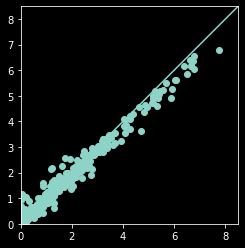

R^2 score: 0.9809938865083286
rmse 0    0.17727
dtype: float64
R^2 score / std: 0    0.137863
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


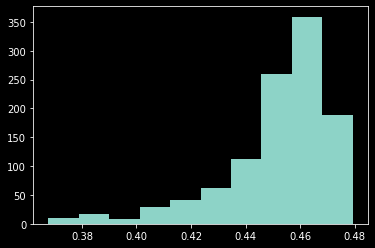

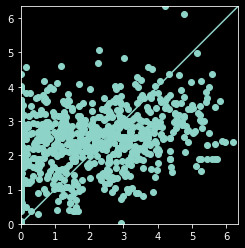

R^2 score: -0.13872557059753232
rmse 0    1.733811
dtype: float64
R^2 score / std: 0    1.067111
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


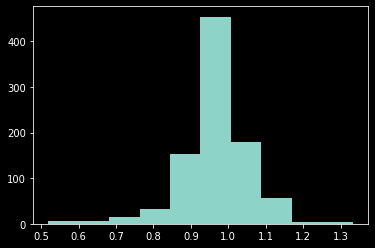

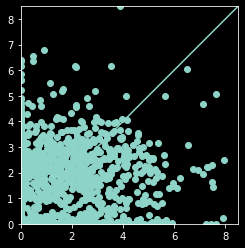

R^2 score: -0.7496754976445383
rmse 2.127490770363343
R^2 score / std: 1.3339213658127669
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


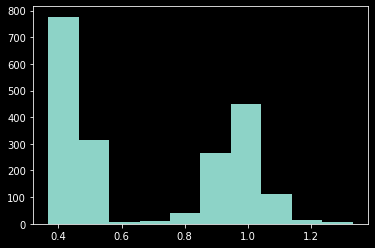

In [33]:
test_domain(comp_zip_y, n = 2000, element = "O", threshold = 0, min_train_group = 500)

Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 56.941
in-domain


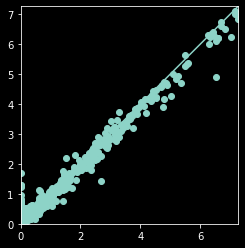

R^2 score: 0.982287664320106
rmse 0    0.18457
dtype: float64
R^2 score / std: 0    0.133088
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


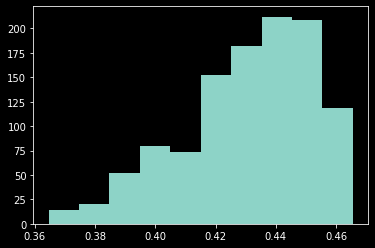

out-domain


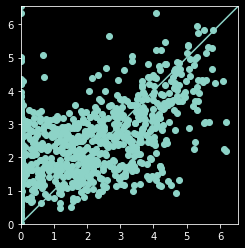

R^2 score: 0.08616139194749184
rmse 0    1.612627
dtype: float64
R^2 score / std: 0    0.955949
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


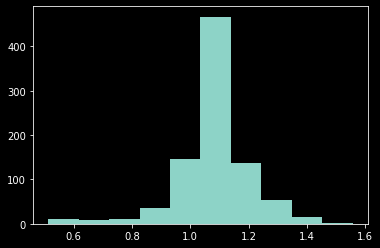

all


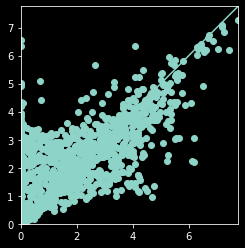

R^2 score: 0.559901434221175
rmse 2.237372463310863
R^2 score / std: 1.3708576102088297
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


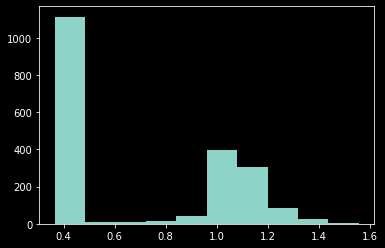

In [44]:
test_domain(comp_zip_y, n = 2000, element = "O", threshold = 0, min_train_group = 500)

Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 11.612
in-domain


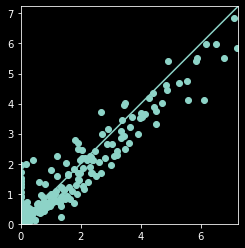

R^2 score: 0.9175245708724186
rmse 0    0.389047
dtype: float64
R^2 score / std: 0    0.287185
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


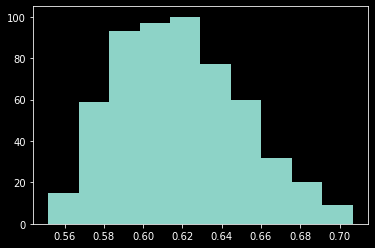

out-domain


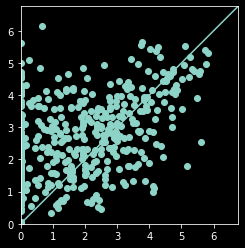

R^2 score: -0.2140979791882538
rmse 0    1.802097
dtype: float64
R^2 score / std: 0    1.101861
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


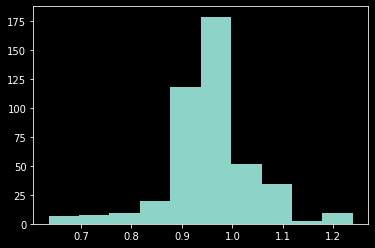

all


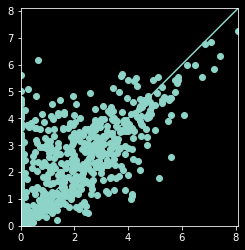

R^2 score: 0.41481305456228945
rmse 2.314206738320401
R^2 score / std: 1.4418567123563657
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


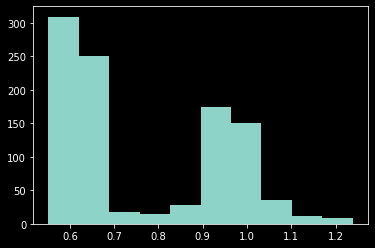

In [45]:
test_domain(comp_zip_y, n = 1000, element = "O", threshold = 0, min_train_group = 500)

O
Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 8.940
in-domain


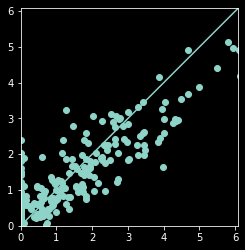

R^2 score: 0.8358274890726611
rmse 0    0.495314
dtype: float64
R^2 score / std: 0    0.405182
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


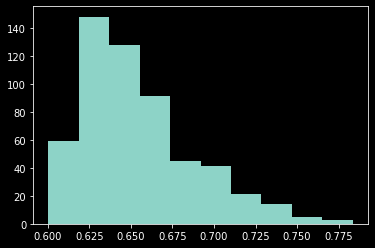

out-domain


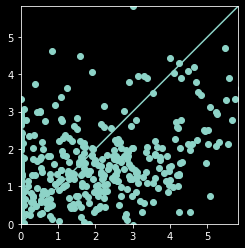

R^2 score: 0.10917094088626533
rmse 0    1.517221
dtype: float64
R^2 score / std: 0    0.943837
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


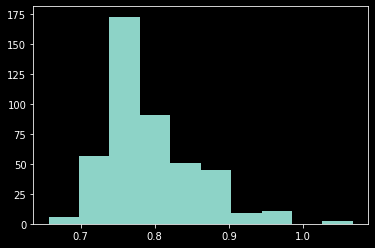

all


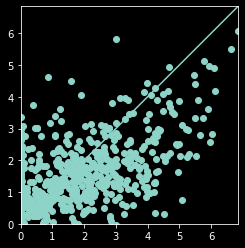

R^2 score: 0.4849918690794508
rmse 1.8637447813673407
R^2 score / std: 1.241551011245053
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


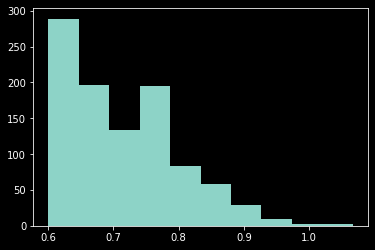


B
Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 39.325
in-domain


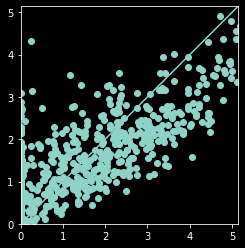

R^2 score: 0.714297666085962
rmse 0    0.850384
dtype: float64
R^2 score / std: 0    0.534511
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


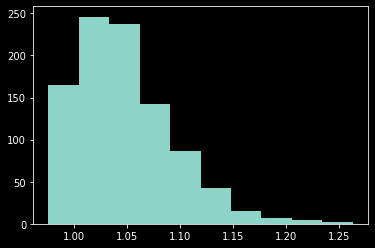

out-domain


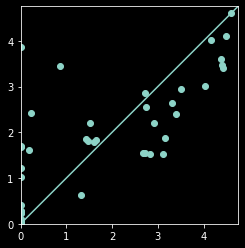

R^2 score: 0.6733997944023493
rmse 0    1.165391
dtype: float64
R^2 score / std: 0    0.571489
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


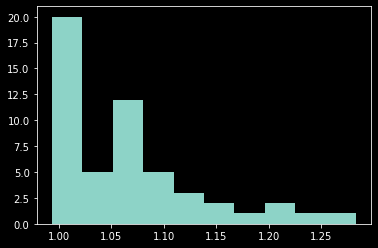

all


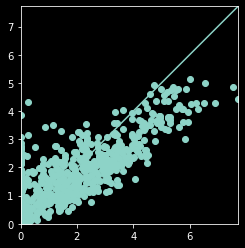

R^2 score: 0.7139246186952672
rmse 2.035753378916846
R^2 score / std: 1.2521464734957684
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


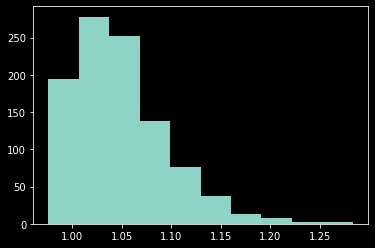


F
Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 61.833
in-domain


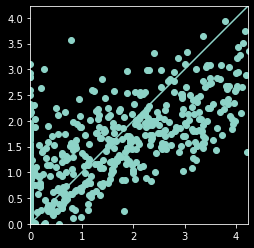

R^2 score: 0.6312471812787779
rmse 0    0.892692
dtype: float64
R^2 score / std: 0    0.60725
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


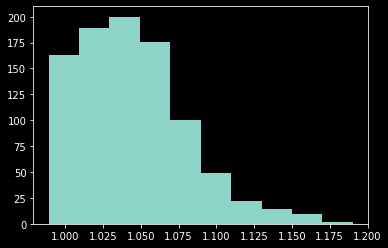

out-domain


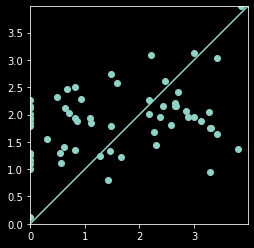

R^2 score: 0.298182238141399
rmse 0    1.552093
dtype: float64
R^2 score / std: 0    0.837746
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


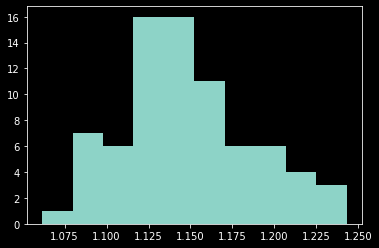

all


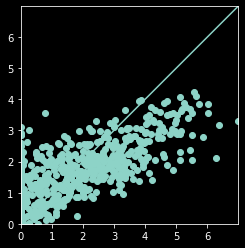

R^2 score: 0.6096880985278439
rmse 1.8616474420693554
R^2 score / std: 1.2129606286098946
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


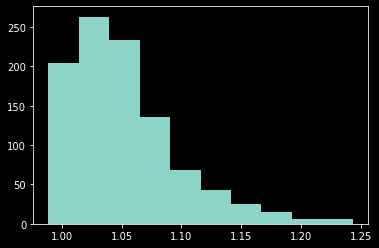


Cl
Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 38.889
in-domain


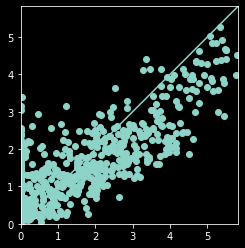

R^2 score: 0.7192931040293327
rmse 0    0.83396
dtype: float64
R^2 score / std: 0    0.529818
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


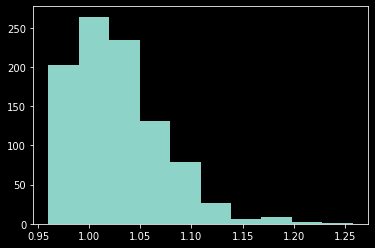

out-domain


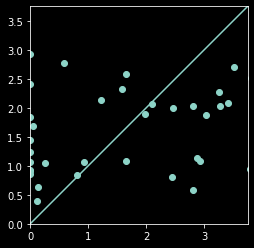

R^2 score: 0.23075332477364463
rmse 0    1.530392
dtype: float64
R^2 score / std: 0    0.877067
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


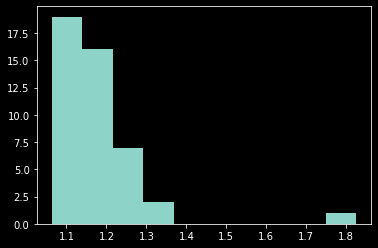

all


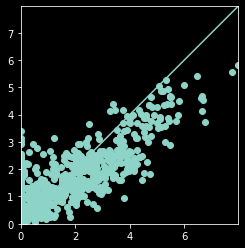

R^2 score: 0.6988922104543012
rmse 1.9934831849750667
R^2 score / std: 1.246937688569957
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


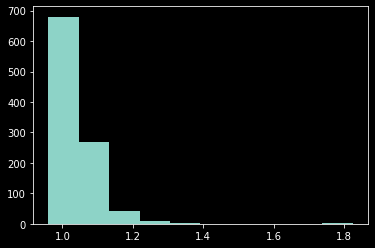


Br
Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 34.765
in-domain


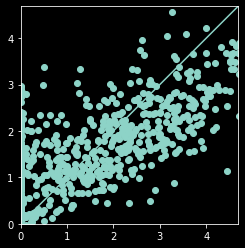

R^2 score: 0.6453194328768177
rmse 0    0.933685
dtype: float64
R^2 score / std: 0    0.595551
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


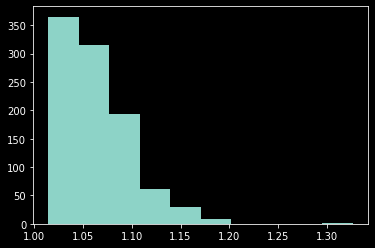

out-domain


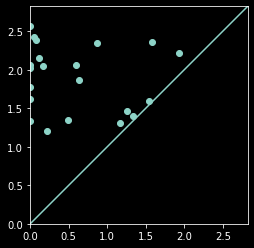

R^2 score: -0.2885003980770746
rmse 0    1.520793
dtype: float64
R^2 score / std: 0    1.135121
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


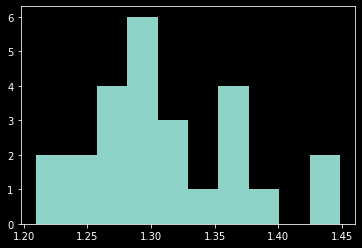

all


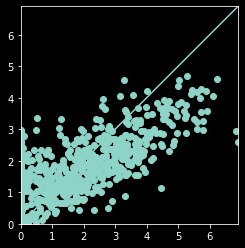

R^2 score: 0.628200700349146
rmse 1.9391611775835034
R^2 score / std: 1.2410077563495288
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


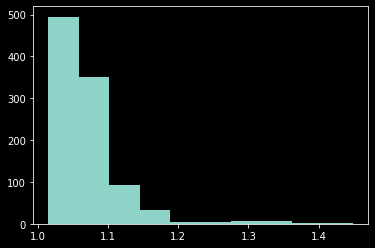


I
Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 38.390
in-domain


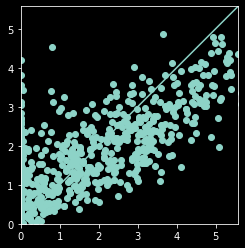

R^2 score: 0.6835138938618744
rmse 0    0.926101
dtype: float64
R^2 score / std: 0    0.562571
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


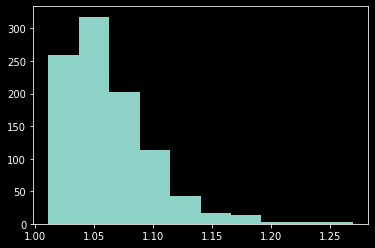

out-domain


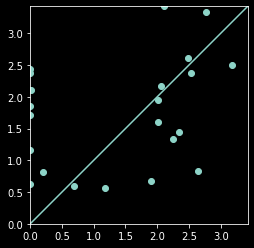

R^2 score: 0.011145191514850827
rmse 0    1.265225
dtype: float64
R^2 score / std: 0    0.994412
dtype: float64
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


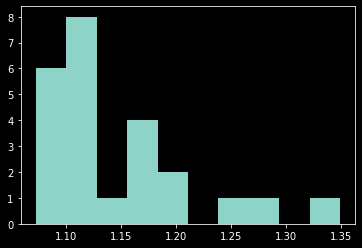

all


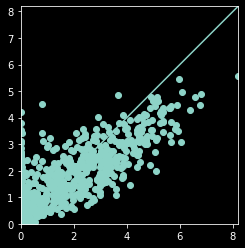

R^2 score: 0.6741653006637421
rmse 2.06284785441349
R^2 score / std: 1.2584559489816822
Uncertainty mean: 1.093690220996738 std: 0.03690527937775899


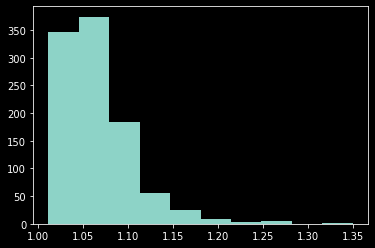

In [46]:
material_group_char = ["O", "B", "F", "Cl", "Br", "I"]
for element in material_group_char:
    print(element)
    test_domain(comp_zip_y, n = 1000, element = element, threshold = 0, min_train_group = 500)
    print()

## OLD CODE

In [47]:
# list(x.items())
# print(*x.items(), sep="\n")
# print(x.iloc[0])

## verify rows sum to 1
# total = x.sum(axis=1, numeric_only= True)
# print("total", total)

# material_group_char = ["O", "B", "F", "Cl", "Br", "I"]
material_group_char = ["O"]
thresholds = [0]
for mat in material_group_char:
    continue
    print("Grouping for", mat)
    st1 = 100
    st2 = 10

    for th in thresholds:
        # Make split
        group_X = x[x[mat] > th]
        not_group_X = x[x[mat] <= th]
        # group_y = [None for x in group_X]
        # not_group_y = [None for x in not_group_y]
        group_y = y[x[mat] > th]
        not_group_y = y[x[mat] <= th]

        perc_in_group = group_X.shape[0]/x.shape[0]
        print(f"\ttheshold:\t{th}\n\tpercent in {mat}_group:\t{perc_in_group}")
        # if the split leaves an empty group skip
        if perc_in_group == 0:
            continue

        # group_X.iloc(100)
        group_X = np.array(group_X)
        group_y = np.array(group_y)

        group_X = group_X[0:1000,:]
        group_y = group_y[0:1000,:]
        
        # do GPR stuff
        print(f"Doing GPR for {mat}")
        # gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(1e-1) 
        gp_kernel = ConstantKernel() * Matern() + WhiteKernel()
        gpr = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=10)
        print("gpr:", gpr)
        # break
        stime = time.time()
        print("Start fitting")
        # gpr.fit(group_X, group_y)
        print("Time for GPR fitting: %.3f" % (time.time() - stime))
        print("Done")

        x_, std_ = gpr.predict(group_X, return_std=True)
        print("x_", x_)
        print("std_", std_)

        # Predict using gaussian process regressor
        # stime = time.time()
        # y_gpr = gpr.predict(X_plot, return_std=False)
        # print("Time for GPR prediction: %.3f" % (time.time() - stime))

# gpr.kernel_
# np.std(group_X)